## Setup

In [1]:
import os
import sys
import math
import numpy as np
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from tqdm.notebook import tqdm, trange
from IPython.display import HTML
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.path import Path
from matplotlib.patches import Rectangle, PathPatch
from tensorflow import keras as K
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/My Drive/iss/prj2/SketchRNN')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
checkpoints  models   setup.py	 train.ipynb
data	     Pipfile  sketchrnn  usage.ipynb


In [4]:

from sketchrnn import models, dataset, utils

sns.set('notebook', 'whitegrid', rc=utils.mpl_rc())

print("tf: {}".format(tf.version.VERSION))
print("tf.keras: {}".format(K.__version__))

tf: 2.3.0
tf.keras: 2.4.0


## Load The Data

In [6]:
data_class = 'rabbit'

# !gsutil cp gs://quickdraw_dataset/sketchrnn/{data_class}.npz .

data = np.load('/content/gdrive/My Drive/iss/prj2/SketchRNN/data/rabbit.npz',encoding='latin1',allow_pickle=True)

In [7]:

data_train = [dataset.cleanup(d) for d in data['train']]
data_valid = [dataset.cleanup(d) for d in data['valid']]
data_test = [dataset.cleanup(d) for d in data['test']]

max_seq_len = max(map(len, np.concatenate([data_train, data_valid, data_test])))
scale_factor = dataset.calc_scale_factor(data_train)

To look at some random samples from the raw test set

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


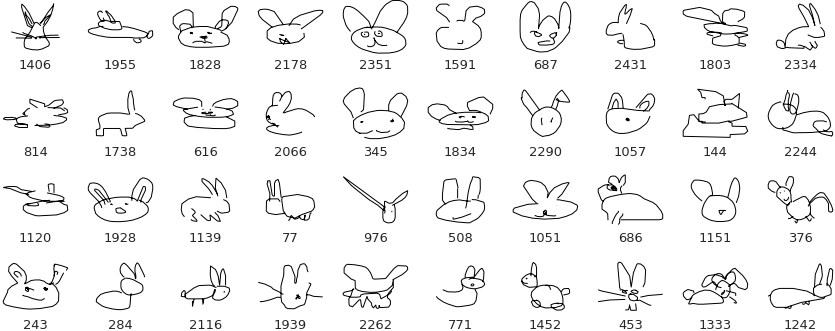

In [8]:
n = [4, 10]

fig, ax = plt.subplots(n[0],n[1],figsize=(12, 5))

perm = np.random.permutation(range(len(data_test)))[:n[0]*n[1]]

for i, idx in enumerate(perm):
    x, y = i // n[1], i % n[1]
    utils.plot_strokes(ax[x][y], data_train[idx])
    ax[x][y].set(xlabel=idx)
    
utils.plt_show()

Some cleanup for later perplexity calculation

In [ ]:
ds_test = np.array([dataset.pad(dataset.normalize(d, scale_factor), max_seq_len) for d in data_test])

In [ ]:
n_points = np.argmax(ds_test[:,:,4]==1,-1)
n_strokes = ds_test[:,:,3].sum(1)

pmin, pmax = np.percentile(n_points,[1,99])
smin, smax = np.percentile(n_strokes,[1,99])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


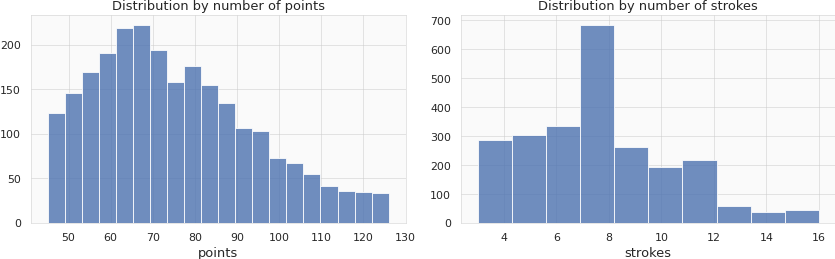

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].hist(n_points[(pmin < n_points) & (n_points < pmax)], 20, alpha=0.8)
ax[0].set(xlabel="points", 
          title="Distribution by number of points")

ax[1].hist(n_strokes[(smin < n_strokes) & (n_strokes < smax)], 10, alpha=0.8)
ax[1].set(xlabel="strokes", 
          title="Distribution by number of strokes")

utils.plt_show()

In [12]:
## Filter invalid samples
ds_test = ds_test[n_points > 0]
n_strokes = n_strokes[n_points > 0]
n_points = n_points[n_points > 0]

## Load The Models

In [13]:
hps = {
    "max_seq_len": max_seq_len,
    'batch_size': 100,
    "num_batches": math.ceil(len(data_train) / 100),
    "epochs": 1,
    "recurrent_dropout_prob": 0.1,
    "enc_rnn_size": 256,
    "dec_rnn_size": 512,
    "z_size": 128,
    "num_mixture": 20,
    "learning_rate": 0.001,
    "min_learning_rate": 0.00001,
    "decay_rate": 0.9999,
    "grad_clip": 1.0,
    'kl_tolerance': 0.2,
    'kl_decay_rate': 0.99995,
    "kl_weight": 0.5,
    'kl_weight_start': 0.01,
}

In [14]:
sketchrnn = models.SketchRNN(hps)
sketchrnn.models['full'].summary()

Model: "sketchrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 131, 5)]     0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 128), (None, 667904      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
initial_state (Functional)      [(None, 512), (None, 132096      encoder[0][0]                    
__________________________________________________________________________________________

In [15]:
initial_epoch, initial_loss = 100, 0.06
#checkpoint = os.path.join('../models/', 'sketch_rnn_{}_weights.{:02d}_{:.2f}.hdf5').format(data_class, initial_epoch, initial_loss)
#sketchrnn.load_weights(checkpoint)

sketchrnn.load_weights('/content/gdrive/My Drive/iss/prj2/SketchRNN/checkpoints/sketch_rnn_rabbit_weights.100_0.06.hdf5')

Loaded Weights From: /content/gdrive/My Drive/iss/prj2/SketchRNN/checkpoints/sketch_rnn_rabbit_weights.100_0.06.hdf5


## Sampling

A random sample from the latent space

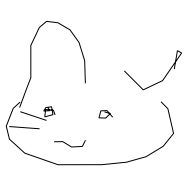

In [34]:
fig, ax = plt.subplots(figsize=(3, 3))

strokes = sketchrnn.sample(temperature=0.3)
utils.plot_strokes(ax, utils.to_normal_strokes(strokes))

utils.plt_show()

The model decode / encode samples with different temperatures

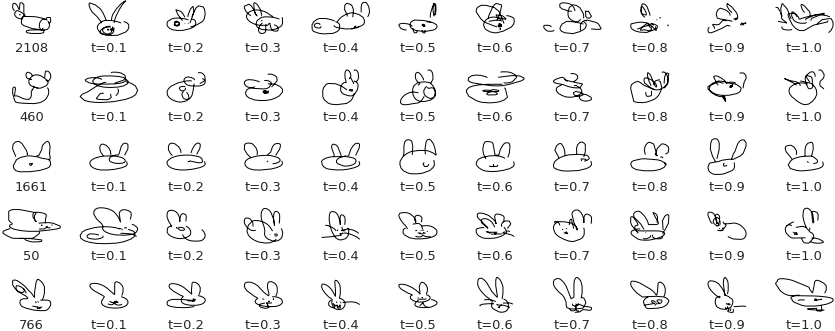

In [40]:
fig = plt.figure(figsize=(12, 5))

n = 5

indices = np.random.permutation(range(len(ds_test)))[:n]

with tqdm(total=n*11) as pbar:
    for i in range(n):
        idx = indices[i]

        d = np.expand_dims(ds_test[idx],0)
        z = sketchrnn.models['encoder'].predict(d[:,1:])[0]

        ax = plt.subplot(n, 11, i * 11 + 1)
        utils.plot_strokes(ax, utils.to_normal_strokes(d[0]))
        ax.set(xlabel=idx)

        pbar.update(1)

        for j in range(1,11):
            strokes = sketchrnn.sample(z=z, temperature=j*0.1)

            ax = plt.subplot(n, 11, i * 11 + j + 1)
            utils.plot_strokes(ax, utils.to_normal_strokes(strokes))
            ax.set(xlabel='t={:.1f}'.format(j*0.1))

            pbar.update(1)

utils.plt_show()

Interpolation between samples

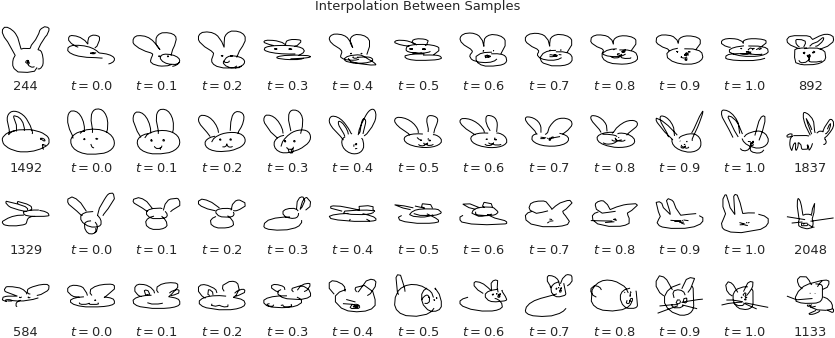

In [42]:
n = 4

indices = np.random.permutation(range(len(ds_test)))[:n * 2]

fig, ax = plt.subplots(n, 13, figsize=(12, 5))

with tqdm(total=n*11) as pbar:
    for i in range(n):
        idx1, idx2 = indices[i*2:i*2+2]

        d1, d2 = ds_test[idx1], ds_test[idx2]
        z1 = sketchrnn.models['encoder'].predict(d1[np.newaxis,1:])[0].squeeze()
        z2 = sketchrnn.models['encoder'].predict(d2[np.newaxis,1:])[0].squeeze()

        utils.plot_strokes(ax[i][0], utils.to_normal_strokes(d1))
        ax[i][0].set(xlabel=idx1)

        for j in range(11):
            z = np.expand_dims(utils.slerp(z1,z2,j*0.1),0)
            strokes = sketchrnn.sample(z=z, greedy=True)
            utils.plot_strokes(ax[i][j+1], utils.to_normal_strokes(strokes))
            ax[i][j+1].set(xlabel='$t={:.1f}$'.format(j*0.1))
            
            pbar.update(1)

        utils.plot_strokes(ax[i][-1], utils.to_normal_strokes(d2))
        ax[i][-1].set(xlabel=idx2)
        
fig.suptitle("Interpolation Between Samples")

utils.plt_show(rect=[0, 0, 1, 0.95])

## Perplexities

We can calculate perplexity using the method from [here](http://colinmorris.github.io/blog/bad_flamingos).

In [43]:
batch_size = 100
n = len(ds_test)

ppxs = np.zeros(n)

for i in trange(n // batch_size + 1):
    batch = ds_test[i*batch_size:(i+1)*batch_size]
    seq_lens = np.argmax(batch[:,:,4]==1,-1)
    
    enc_in, dec_in = batch[:,1:], batch[:,:-1]
    outputs = sketchrnn.models['full']([enc_in, dec_in])[0]
    loss = models.calculate_md_loss(enc_in, outputs)
    
    ppxs[i*batch_size:(i+1)*batch_size] = tf.math.reduce_sum(tf.squeeze(loss),-1) / seq_lens

In [44]:
norm = mpl.colors.Normalize(vmin=ppxs.min(), vmax=ppxs.max())
cmap = mpl.cm.get_cmap('RdYlBu')

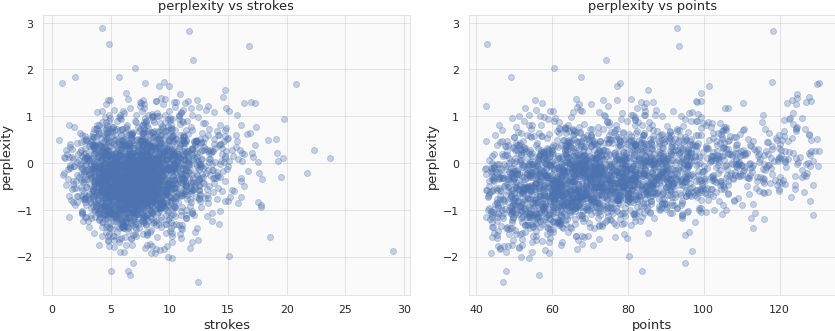

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].plot(n_strokes - (np.random.rand(len(n_strokes)) - .5), ppxs, 'bo',alpha=0.3)
ax[0].set(xlabel="strokes", ylabel="perplexity",
          title="perplexity vs strokes")

ax[1].plot(n_points - (np.random.rand(len(n_points)) - .5), ppxs, 'bo',alpha=0.3)
ax[1].set(xlabel="points", ylabel="perplexity",
          title="perplexity vs points")

utils.plt_show()

Here are the best samples with best scores

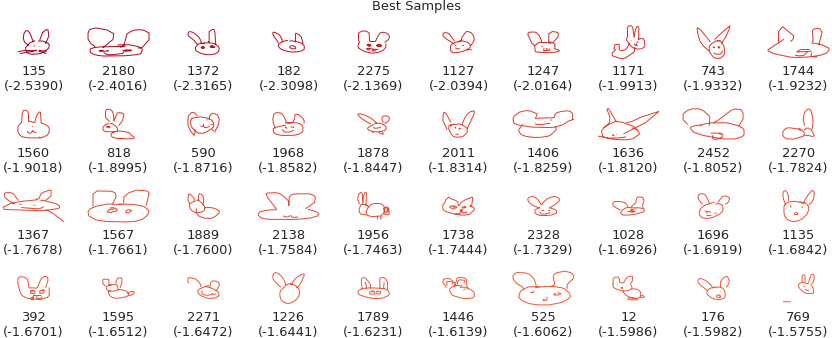

In [46]:
n = [4, 10]

fig, ax = plt.subplots(n[0],n[1],figsize=(12, 5))

perm = np.argsort(ppxs)[:n[0]*n[1]]

for i, idx in enumerate(perm):
    x, y = i // n[1], i % n[1]
    utils.plot_strokes(ax[x][y], utils.to_normal_strokes(ds_test[idx]), ec=cmap(norm(ppxs[idx])))
    ax[x][y].set(xlabel='{}\n({:.4f})'.format(idx, ppxs[idx]))
    
fig.suptitle("Best Samples")
    
utils.plt_show(rect=[0, 0, 1, 0.95])

and the worst ones...

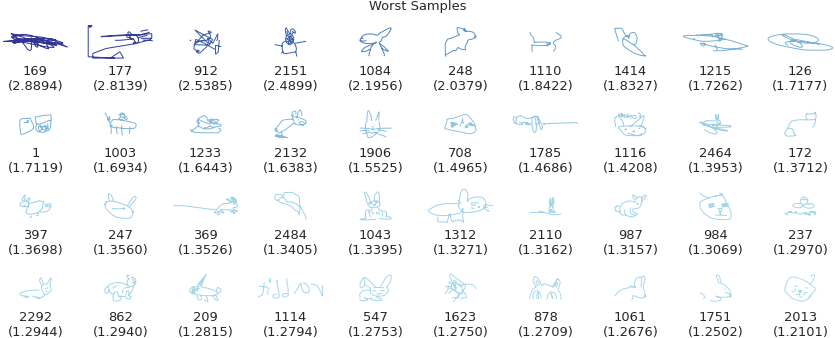

In [47]:
n = [4, 10]

fig, ax = plt.subplots(n[0],n[1],figsize=(12, 5))

perm = np.argsort(ppxs)[-n[0]*n[1]:][::-1]

for i, idx in enumerate(perm):
    x, y = i // n[1], i % n[1]
    utils.plot_strokes(ax[x][y], utils.to_normal_strokes(ds_test[idx]), ec=cmap(norm(ppxs[idx])))
    ax[x][y].set(xlabel='{}\n({:.4f})'.format(idx,ppxs[idx]))
    
fig.suptitle("Worst Samples")
    
utils.plt_show(rect=[0, 0, 1, 0.95])